<a href="https://colab.research.google.com/github/noel-odero/cervical-cancer-prediction/blob/main/model-trainig/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [149]:
# CELL 1: Imports and configuration
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFE, SelectKBest, f_regression

from imblearn.over_sampling import SMOTE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import joblib
import os

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Plot defaults
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

print("Environment ready. Random seed:", RANDOM_STATE)


Environment ready. Random seed: 42


In [150]:
df = pd.read_csv("/content/risk_factors_cervical_cancer.csv")
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Age                                 858 non-null    int64 
 1   Number of sexual partners           858 non-null    object
 2   First sexual intercourse            858 non-null    object
 3   Num of pregnancies                  858 non-null    object
 4   Smokes                              858 non-null    object
 5   Smokes (years)                      858 non-null    object
 6   Smokes (packs/year)                 858 non-null    object
 7   Hormonal Contraceptives             858 non-null    object
 8   Hormonal Contraceptives (years)     858 non-null    object
 9   IUD                                 858 non-null    object
 10  IUD (years)                         858 non-null    object
 11  STDs                                858 non-null    object

In [151]:
# Basic dataset report
print("=== BASIC INFO ===")
display(df.info())

print("\n=== SUMMARY STATISTICS (numeric) ===")
display(df.describe(include=[np.number]).T)

print("\n=== Missing values (counts & percent) ===")
missing = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing / len(df) * 100).round(2)
missing_report = pd.DataFrame({"missing_count": missing, "missing_percent": missing_percent})
display(missing_report[missing_report["missing_count"] > 0])

=== BASIC INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Age                                 858 non-null    int64 
 1   Number of sexual partners           858 non-null    object
 2   First sexual intercourse            858 non-null    object
 3   Num of pregnancies                  858 non-null    object
 4   Smokes                              858 non-null    object
 5   Smokes (years)                      858 non-null    object
 6   Smokes (packs/year)                 858 non-null    object
 7   Hormonal Contraceptives             858 non-null    object
 8   Hormonal Contraceptives (years)     858 non-null    object
 9   IUD                                 858 non-null    object
 10  IUD (years)                         858 non-null    object
 11  STDs                                858

None


=== SUMMARY STATISTICS (numeric) ===


,count,mean,std,min,25%,50%,75%,max
Age,858.0,26.820513,8.497948,13.0,20.0,25.0,32.0,84.0
STDs: Number of diagnosis,858.0,0.087413,0.302545,0.0,0.0,0.0,0.0,3.0
Dx:Cancer,858.0,0.020979,0.143398,0.0,0.0,0.0,0.0,1.0
Dx:CIN,858.0,0.010490,0.101939,0.0,0.0,0.0,0.0,1.0
Dx:HPV,858.0,0.020979,0.143398,0.0,0.0,0.0,0.0,1.0
Dx,858.0,0.027972,0.164989,0.0,0.0,0.0,0.0,1.0
Hinselmann,858.0,0.040793,0.197925,0.0,0.0,0.0,0.0,1.0
Schiller,858.0,0.086247,0.280892,0.0,0.0,0.0,0.0,1.0
Citology,858.0,0.051282,0.220701,0.0,0.0,0.0,0.0,1.0
Biopsy,858.0,0.064103,0.245078,0.0,0.0,0.0,0.0,1.0



=== Missing values (counts & percent) ===


,missing_count,missing_percent


In [152]:
#  Cardinality analysis
print("\nCARDINALITY ANALYSIS (categorical / low-cardinality features)\n")
low_card_cols = []
for col in df.columns:
    unique_count = df[col].nunique(dropna=True)
    if unique_count <= 10:
        low_card_cols.append(col)
        print(f"{col}: unique={unique_count}")
        print(df[col].value_counts(dropna=False))
        print("-" * 40)

print("Detected low-cardinality columns (<=10 unique values):", low_card_cols)



CARDINALITY ANALYSIS (categorical / low-cardinality features)

Smokes: unique=3
Smokes
0.0    722
1.0    123
?       13
Name: count, dtype: int64
----------------------------------------
Hormonal Contraceptives: unique=3
Hormonal Contraceptives
1.0    481
0.0    269
?      108
Name: count, dtype: int64
----------------------------------------
IUD: unique=3
IUD
0.0    658
?      117
1.0     83
Name: count, dtype: int64
----------------------------------------
STDs: unique=3
STDs
0.0    674
?      105
1.0     79
Name: count, dtype: int64
----------------------------------------
STDs (number): unique=6
STDs (number)
0.0    674
?      105
2.0     37
1.0     34
3.0      7
4.0      1
Name: count, dtype: int64
----------------------------------------
STDs:condylomatosis: unique=3
STDs:condylomatosis
0.0    709
?      105
1.0     44
Name: count, dtype: int64
----------------------------------------
STDs:cervical condylomatosis: unique=2
STDs:cervical condylomatosis
0.0    753
?      105
Name:

In [153]:
# Replace '?' placeholders with NaN
df.replace('?', np.nan, inplace=True)

# Convert all columns to numeric where possible (invalid parsing → NaN)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Print number of missing values per column
print("Missing values after conversion:\n")
print(df.isna().sum())


Missing values after conversion:

Age                                     0
Number of sexual partners              26
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives               108
Hormonal Contraceptives (years)       108
IUD                                   117
IUD (years)                           117
STDs                                  105
STDs (number)                         105
STDs:condylomatosis                   105
STDs:cervical condylomatosis          105
STDs:vaginal condylomatosis           105
STDs:vulvo-perineal condylomatosis    105
STDs:syphilis                         105
STDs:pelvic inflammatory disease      105
STDs:genital herpes                   105
STDs:molluscum contagiosum            105
STDs:AIDS                             105
STDs:HIV                              105


In [154]:
# Identify diagnostic targets and choose approach
diagnostic_targets = [c for c in ["Hinselmann", "Schiller", "Cytology", "Biopsy"] if c in df.columns]
print("Diagnostic targets detected:", diagnostic_targets)

PRIMARY_TARGET = "Biopsy" if "Biopsy" in df.columns else diagnostic_targets[0]
print("PRIMARY_TARGET chosen:", PRIMARY_TARGET)


# weighted composite risk score for EDA
weights = {'Biopsy':0.4, 'Cytology':0.25, 'Schiller':0.2, 'Hinselmann':0.15}
df['CervicalCancer_RiskScore'] = 0.0
total_weight = 0.0
for test in diagnostic_targets:
    if test in weights:
        df['CervicalCancer_RiskScore'] += df[test].fillna(0) * weights[test]
        total_weight += weights[test]
if total_weight > 0:
    df['CervicalCancer_RiskScore'] /= total_weight

print(f"\nCreated weighted continuous target (for EDA): 'CervicalCancer_RiskScore'")
print(df['CervicalCancer_RiskScore'].describe())


Diagnostic targets detected: ['Hinselmann', 'Schiller', 'Biopsy']
PRIMARY_TARGET chosen: Biopsy

Created weighted continuous target (for EDA): 'CervicalCancer_RiskScore'
count    858.000000
mean       0.065346
std        0.219409
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: CervicalCancer_RiskScore, dtype: float64


In [155]:
# Prepare feature matrix (exclude diagnostic columns from predictors)
exclude_cols = diagnostic_targets + ['CervicalCancer_RiskScore']
feature_cols = [c for c in df.columns if c not in exclude_cols]

X_raw = df[feature_cols].copy()
y_raw = df[PRIMARY_TARGET].astype(float).copy()

print("Feature matrix shape:", X_raw.shape)
print("Target variable distribution:\n", y_raw.value_counts())

Feature matrix shape: (858, 33)
Target variable distribution:
 Biopsy
0.0    803
1.0     55
Name: count, dtype: int64


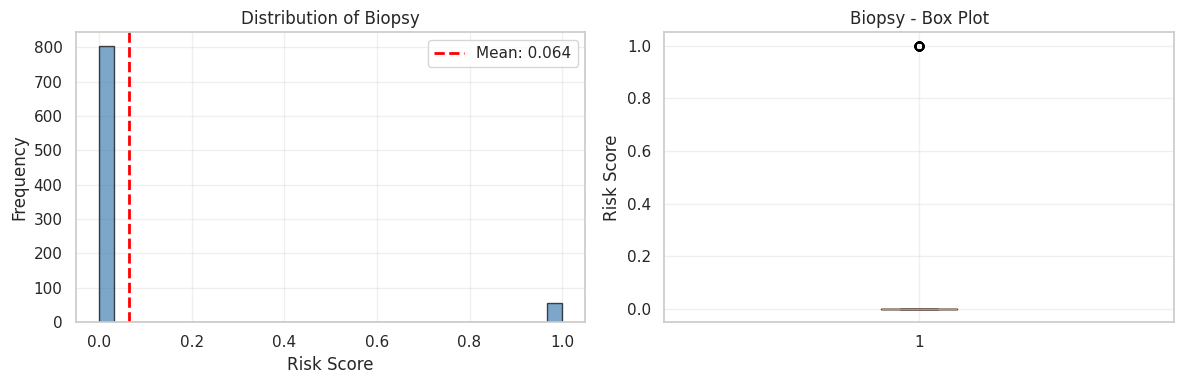

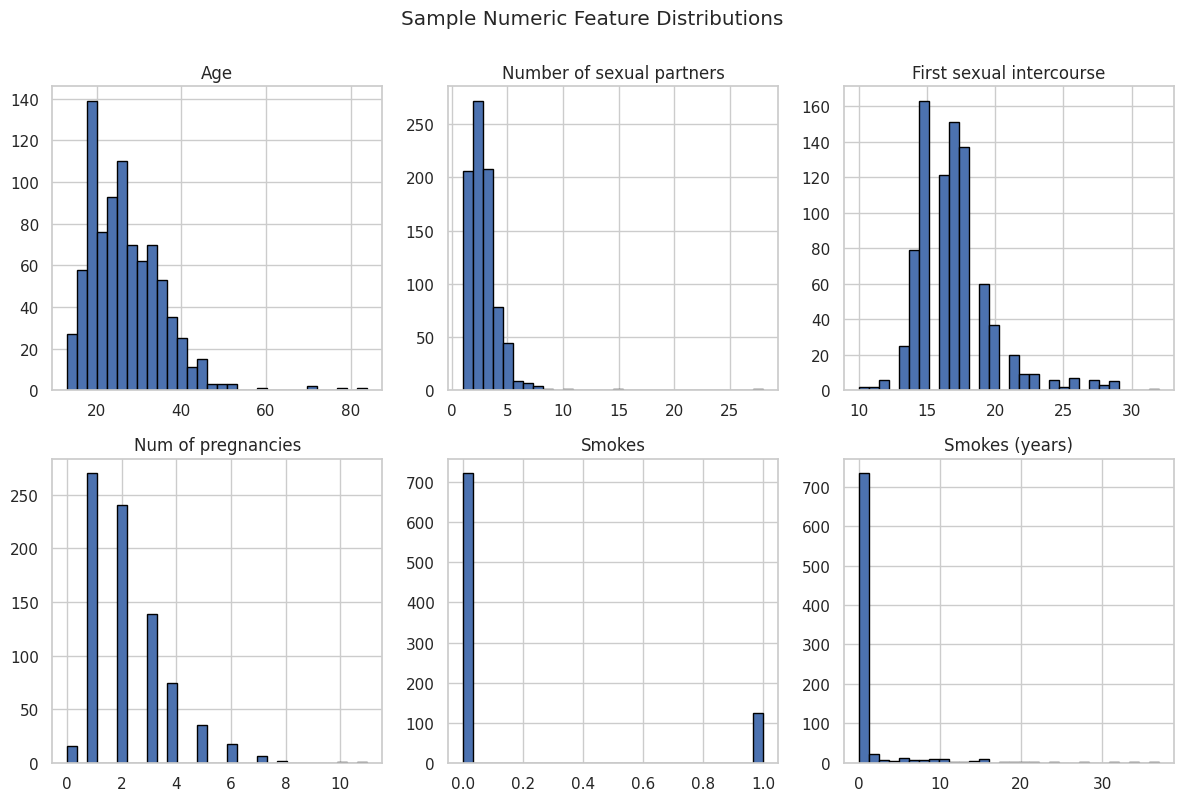

In [156]:
# Simple EDA plots
# 1) Distribution of continuous target
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
axes[0].hist(y_raw.dropna(), bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Risk Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Distribution of {PRIMARY_TARGET}')
axes[0].axvline(y_raw.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {y_raw.mean():.3f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(y_raw.dropna(), vert=True)
axes[1].set_ylabel('Risk Score')
axes[1].set_title(f'{PRIMARY_TARGET} - Box Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2) Histograms for a sample of numeric features
numeric_sample = X_raw.select_dtypes(include=[np.number]).columns[:6].tolist()
X_raw[numeric_sample].hist(bins=30, layout=(2,3), figsize=(12,8), edgecolor='black')
plt.suptitle("Sample Numeric Feature Distributions", y=1.00)
plt.tight_layout()
plt.show()


In [157]:
# Compare KNNImputer vs IterativeImputer (MICE) using quick cross-validation
numeric_features = X_raw.select_dtypes(include=[np.number]).columns.tolist()
X_numeric = X_raw[numeric_features].copy()

# Simple temporary model for comparison
temp_model = LinearRegression()

# KNN imputer
knn_imp = KNNImputer(n_neighbors=5, weights='distance')
X_knn = pd.DataFrame(knn_imp.fit_transform(X_numeric), columns=numeric_features, index=X_numeric.index)

# Iterative (MICE)
iter_imp = IterativeImputer(random_state=RANDOM_STATE, max_iter=10)
X_iter = pd.DataFrame(iter_imp.fit_transform(X_numeric), columns=numeric_features, index=X_numeric.index)

# Compare by CV (use rows where target is not null)
mask = y_raw.notnull()
cv_knn = cross_val_score(temp_model, X_knn[mask], y_raw[mask].astype(float), cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
cv_iter = cross_val_score(temp_model, X_iter[mask], y_raw[mask].astype(float), cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

rmse_knn = np.sqrt(-cv_knn.mean())
rmse_iter = np.sqrt(-cv_iter.mean())

print(f"KNN Imputer RMSE (3-fold CV): {rmse_knn:.4f}")
print(f"Iterative Imputer RMSE (3-fold CV): {rmse_iter:.4f}")

# Choose the better imputer for numeric columns
if rmse_iter <= rmse_knn:
    chosen_imputer = iter_imp
    X_num_imputed = X_iter
    print("Selected: IterativeImputer (MICE)")
else:
    chosen_imputer = knn_imp
    X_num_imputed = X_knn
    print("Selected: KNNImputer")


KNN Imputer RMSE (3-fold CV): 0.2402
Iterative Imputer RMSE (3-fold CV): 565986.4882
Selected: KNNImputer


In [158]:
# Impute categorical features (if any) and reassemble X_imputed
cat_features = X_raw.select_dtypes(include=['object', 'category']).columns.tolist()
if cat_features:
    cat_imp = SimpleImputer(strategy='most_frequent')
    X_cat_imputed = pd.DataFrame(cat_imp.fit_transform(X_raw[cat_features]), columns=cat_features, index=X_raw.index)
    print("Categorical features imputed:", cat_features)
    # Merge numeric and categorical back
    X_imputed = pd.concat([X_num_imputed, X_cat_imputed], axis=1)
else:
    X_imputed = X_num_imputed.copy()

print("Final imputed feature shape:", X_imputed.shape)


Final imputed feature shape: (858, 33)


In [159]:
# Outlier detection summary using IQR
def iqr_outlier_bounds(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return Q1 - 1.5*IQR, Q3 + 1.5*IQR

outlier_summary = []
for col in X_imputed.select_dtypes(include=[np.number]).columns:
    lb, ub = iqr_outlier_bounds(X_imputed[col])
    n_out = ((X_imputed[col] < lb) | (X_imputed[col] > ub)).sum()
    outlier_summary.append((col, n_out, n_out / len(X_imputed) * 100))

outlier_df = pd.DataFrame(outlier_summary, columns=["feature", "n_outliers", "pct"])
outlier_df = outlier_df.sort_values("n_outliers", ascending=False).reset_index(drop=True)
display(outlier_df.head(10))


,feature,n_outliers,pct
0,Smokes,128,14.918415
1,Smokes (packs/year),128,14.918415
2,Smokes (years),128,14.918415
3,IUD (years),117,13.636364
4,IUD,117,13.636364
5,STDs (number),97,11.305361
6,STDs,97,11.305361
7,STDs: Number of diagnosis,71,8.275058
8,Hormonal Contraceptives (years),70,8.158508
9,Number of sexual partners,69,8.041958


In [160]:
# Winsorize numeric columns at 5%/95% and test impact via CV
from scipy.stats.mstats import winsorize

X_wins = X_imputed.copy()
numeric_cols = X_wins.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols:
    vals = X_wins[col].values
    # handle NaN safe (should be none)
    X_wins[col] = winsorize(vals, limits=[0.05, 0.05])

# Quick CV comparison with a simple linear model
mask = y_raw.notnull()
cv_before = cross_val_score(LinearRegression(), X_imputed[mask], y_raw[mask].astype(float), cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
cv_after = cross_val_score(LinearRegression(), X_wins[mask], y_raw[mask].astype(float), cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

rmse_before = np.sqrt(-cv_before.mean())
rmse_after = np.sqrt(-cv_after.mean())
print("RMSE before winsorize:", round(rmse_before, 4))
print("RMSE after winsorize: ", round(rmse_after, 4))

# Choose winsorized or original based on RMSE
if rmse_after <= rmse_before:
    X_processed = X_wins.copy()
    print("Using winsorized data (improvement or equal).")
else:
    X_processed = X_imputed.copy()
    print("Keeping original imputed data (winsorization worsened CV).")


RMSE before winsorize: 0.2402
RMSE after winsorize:  0.2407
Keeping original imputed data (winsorization worsened CV).


In [161]:
# CELL 14: Feature engineering - add derived features where possible
X_eng = X_processed.copy()

# Example engineered features (create only if required columns exist)
if 'Age' in X_eng.columns and 'First sexual intercourse' in X_eng.columns:
    X_eng['Sexual_Activity_Years'] = (X_eng['Age'] - X_eng['First sexual intercourse']).clip(lower=0)

if 'Smokes' in X_eng.columns and 'Smokes (years)' in X_eng.columns:
    X_eng['Smoking_Risk'] = X_eng['Smokes'].fillna(0) * X_eng['Smokes (years)'].fillna(0)

if 'Num of pregnancies' in X_eng.columns:
    X_eng['High_Parity'] = (X_eng['Num of pregnancies'] >= 3).astype(int)
    X_eng['Pregnancy_Risk_Category'] = pd.cut(X_eng['Num of pregnancies'], bins=[-1,0,2,5,100], labels=[0,1,2,3]).astype(float)

# STD aggregation example
std_cols = [c for c in X_eng.columns if 'STDs' in c and X_eng[c].dtype in (np.number, 'float64', 'int64')]
if len(std_cols) > 0:
    X_eng['STD_Count'] = X_eng[std_cols].sum(axis=1)

print("Feature engineering complete. New shape:", X_eng.shape)


Feature engineering complete. New shape: (858, 38)


,0
Citology,0.327466
Dx:Cancer,0.160905
Dx:HPV,0.160905
Dx,0.157607
STDs:genital herpes,0.130523
STDs:HIV,0.125482
Dx:CIN,0.113172
STDs,0.110803
STDs (number),0.100243
STDs: Number of diagnosis,0.097449


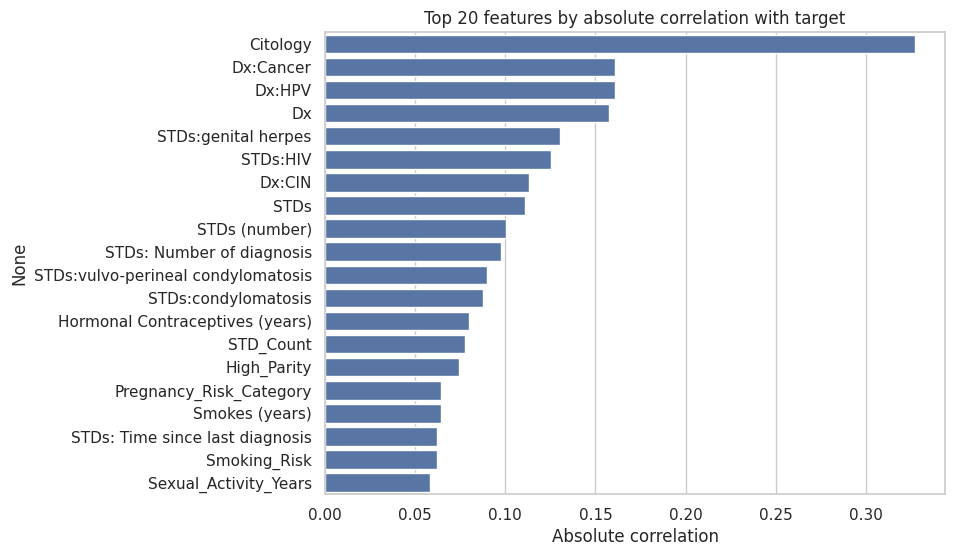

In [162]:
# Correlation with target (absolute value) and top correlated features
y_float = y_raw.astype(float)
mask = y_float.notnull()
correlations = X_eng.corrwith(y_float).abs().sort_values(ascending=False)
top_corr = correlations.head(20)
display(top_corr)
plt.figure(figsize=(8,6))
sns.barplot(x=top_corr.values, y=top_corr.index)
plt.title("Top 20 features by absolute correlation with target")
plt.xlabel("Absolute correlation")
plt.show()


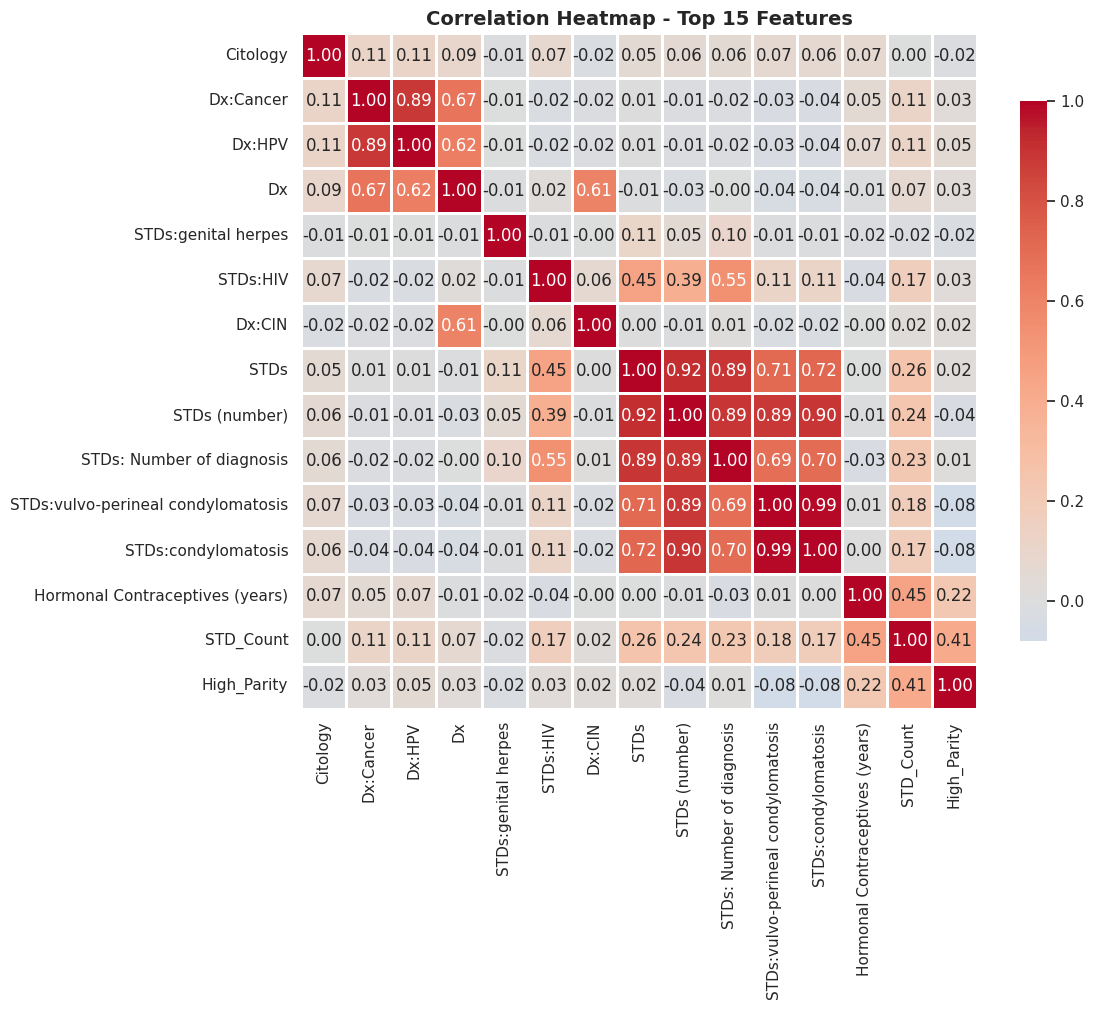

In [163]:
# CORRELATION HEATMAP
plt.figure(figsize=(12, 10))

# Select top correlated features for readability
top_features = top_corr.head(15).index.tolist()
corr_matrix = X_eng[top_features].corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap - Top 15 Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [164]:
#  Compute VIF and iteratively drop high-VIF features

def compute_vif(df_in):
    """
    Computes VIF safely without index errors.
    Works only on numeric columns.
    """
    X_vif = df_in.select_dtypes(include=[np.number]).dropna(axis=1, how='all')
    X_const = sm.add_constant(X_vif)

    vif_list = []
    for i in range(1, X_const.shape[1]):      # start at 1 to skip constant column
        vif_list.append({
            "feature": X_vif.columns[i-1],    # map correctly to original columns
            "VIF": variance_inflation_factor(X_const.values, i)
        })

    return pd.DataFrame(vif_list).sort_values("VIF", ascending=False)


# Start VIF on encoded & scaled data
X_for_vif = X_eng.select_dtypes(include=[np.number]).copy()

vif_df = compute_vif(X_for_vif)
display(vif_df.head(15))

# Iterative VIF Reduction
threshold = 10
X_vif_reduced = X_for_vif.copy()
dropped = []

while True:
    vif_local = compute_vif(X_vif_reduced)

    max_vif = vif_local["VIF"].max()
    max_feature = vif_local.iloc[0]["feature"]

    if max_vif > threshold:

        # protect top correlated features
        if max_feature in top_corr.index[:10]:
            alt = vif_local[~vif_local["feature"].isin(top_corr.index[:10])]
            if alt.shape[0] == 0:
                print("Reached limit: Remaining high-VIF features are top predictors. Stopping.")
                break
            max_feature = alt.iloc[0]["feature"]

        print(f"Dropping due to VIF: {max_feature}")
        X_vif_reduced = X_vif_reduced.drop(columns=[max_feature])
        dropped.append(max_feature)

    else:
        print("All VIF values below threshold.")
        break

print("\nDropped features (VIF reduction):", dropped)
print("Remaining features after VIF reduction:", X_vif_reduced.shape[1])


,feature,VIF
17,STDs:syphilis,inf
18,STDs:pelvic inflammatory disease,inf
19,STDs:genital herpes,inf
11,STDs,inf
20,STDs:molluscum contagiosum,inf
37,STD_Count,inf
27,STDs: Time since last diagnosis,inf
26,STDs: Time since first diagnosis,inf
16,STDs:vulvo-perineal condylomatosis,inf
15,STDs:vaginal condylomatosis,inf


Dropping due to VIF: STDs:syphilis
Dropping due to VIF: STDs: Time since first diagnosis
Dropping due to VIF: Age
Dropping due to VIF: Smokes (years)
Dropping due to VIF: STD_Count
Dropping due to VIF: STDs:vulvo-perineal condylomatosis
Dropping due to VIF: STDs:condylomatosis
Dropping due to VIF: Pregnancy_Risk_Category
Dropping due to VIF: Smoking_Risk
Dropping due to VIF: Num of pregnancies
Dropping due to VIF: STDs: Time since last diagnosis
Dropping due to VIF: IUD
Dropping due to VIF: Sexual_Activity_Years
Dropping due to VIF: Smokes (packs/year)
Dropping due to VIF: Hormonal Contraceptives (years)
Dropping due to VIF: STDs:HPV
Dropping due to VIF: STDs:vaginal condylomatosis
All VIF values below threshold.

Dropped features (VIF reduction): ['STDs:syphilis', 'STDs: Time since first diagnosis', 'Age', 'Smokes (years)', 'STD_Count', 'STDs:vulvo-perineal condylomatosis', 'STDs:condylomatosis', 'Pregnancy_Risk_Category', 'Smoking_Risk', 'Num of pregnancies', 'STDs: Time since last d

In [192]:
# Final features and check for any NaNs
final_numeric = X_vif_reduced.columns.tolist()
# include any important categorical columns that were not in numeric VIF step
final_categorical = [c for c in X_eng.columns if c not in final_numeric and X_eng[c].dtype == 'O']
all_candidate_features = final_numeric + final_categorical

print(f" Total features after VIF reduction: {len(all_candidate_features)}")
print(f"   - Numeric: {len(final_numeric)}")
print(f"   - Categorical: {len(final_categorical)}")


# Use first 15 from VIF-reduced numeric features (already sorted by importance)
final_features = final_numeric[:10]
print(len(final_features))
print(final_features)


X_final = X_eng[final_features].copy()
y_final = y_raw.astype(float)

print(f"   Any NaNs in X_final: {X_final.isnull().sum().sum()}")


final_features_list = X_final.columns.tolist()
print(f"\n Features to save in feature_list.pkl:")
print(final_features_list)



 Total features after VIF reduction: 21
   - Numeric: 21
   - Categorical: 0
10
['Number of sexual partners', 'First sexual intercourse', 'Smokes', 'Hormonal Contraceptives', 'IUD (years)', 'STDs', 'STDs (number)', 'STDs:cervical condylomatosis', 'STDs:pelvic inflammatory disease', 'STDs:genital herpes']
   Any NaNs in X_final: 0

 Features to save in feature_list.pkl:
['Number of sexual partners', 'First sexual intercourse', 'Smokes', 'Hormonal Contraceptives', 'IUD (years)', 'STDs', 'STDs (number)', 'STDs:cervical condylomatosis', 'STDs:pelvic inflammatory disease', 'STDs:genital herpes']


In [193]:
# Prepare column lists for transformation and apply scaling & encoding
from sklearn.preprocessing import OneHotEncoder

# Identify categorical features for OHE (only low-cardinality ones)
cat_cols = [c for c in X_final.columns if X_final[c].dtype == 'O']
num_cols = [c for c in X_final.columns if c not in cat_cols]

print("Numeric cols:", len(num_cols), "Categorical cols (to OHE):", cat_cols)

# Pipeline: Simple imputer for numeric (should be none), scaler; OHE for categorical
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ], remainder='drop'
)

# Fit preprocessor on full data (we will use train/test split soon)
X_prepared = preprocessor.fit_transform(X_final)
print("Transformed feature shape (after OHE & scaling):", X_prepared.shape)


Numeric cols: 10 Categorical cols (to OHE): []
Transformed feature shape (after OHE & scaling): (858, 10)


In [194]:
#  Train/test split using prepared preprocessor output
X_prepared_df = pd.DataFrame(X_prepared)  # using transformed features as a DataFrame for train_test_split
# Align the y to the same index
mask = y_final.notnull()
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_prepared_df[mask], y_final[mask], test_size=0.25, random_state=RANDOM_STATE)

print("Train shape:", X_train_raw.shape)
print("Test shape:", X_test_raw.shape)


Train shape: (643, 10)
Test shape: (215, 10)


In [195]:
# Train baseline models
models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(random_state=RANDOM_STATE),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
}

baseline_results = {}
for name, model in models.items():
    model.fit(X_train_raw, y_train)
    preds = model.predict(X_test_raw)
    baseline_results[name] = {
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "MAE": mean_absolute_error(y_test, preds),
        "R2": r2_score(y_test, preds)
    }

pd.DataFrame(baseline_results).T.sort_values("RMSE")


,RMSE,MAE,R2
LinearRegression,0.230038,0.111915,-0.004152
RandomForest,0.255057,0.111862,-0.234452
DecisionTree,0.308643,0.119448,-0.807647


In [169]:
#  Hyperparameter tuning for RandomForest (GridSearchCV)
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

rf = RandomForestRegressor(random_state=RANDOM_STATE)
grid = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid.fit(X_train_raw, y_train)

print("Best RF params:", grid.best_params_)
best_rf = grid.best_estimator_

# Evaluate best RF on test set
rf_preds = best_rf.predict(X_test_raw)
print("RF Test RMSE:", np.sqrt(mean_squared_error(y_test, rf_preds)))
print("RF Test R2:", r2_score(y_test, rf_preds))


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best RF params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
RF Test RMSE: 0.24428246398566134
RF Test R2: -0.13235921765153025


In [170]:
# Collect final model performances and select best by RMSE
final_models = {
    "LinearRegression": LinearRegression().fit(X_train_raw, y_train),
    "DecisionTree": DecisionTreeRegressor(random_state=RANDOM_STATE).fit(X_train_raw, y_train),
    "RandomForest_Tuned": best_rf
}

final_results = {}
for name, model in final_models.items():
    preds = model.predict(X_test_raw)
    final_results[name] = {
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "MAE": mean_absolute_error(y_test, preds),
        "R2": r2_score(y_test, preds)
    }

final_df = pd.DataFrame(final_results).T.sort_values("RMSE")
display(final_df)
best_model_name = final_df.index[0]
print("Best model by RMSE:", best_model_name)
best_model = final_models[best_model_name]


,RMSE,MAE,R2
LinearRegression,0.230038,0.111915,-0.004152
RandomForest_Tuned,0.244282,0.113974,-0.132359
DecisionTree,0.308643,0.119448,-0.807647


Best model by RMSE: LinearRegression


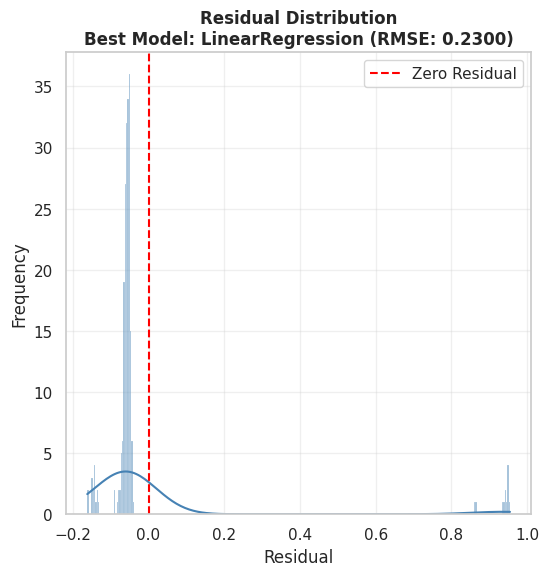

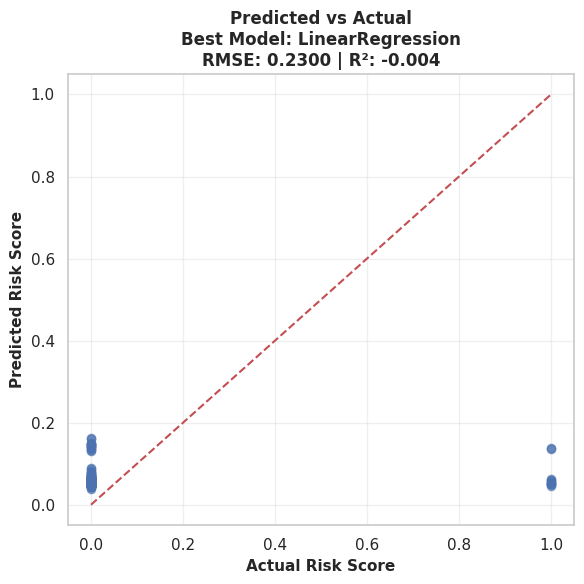


 Residual diagnostics completed for: LinearRegression
 RMSE: 0.2300
 R²: -0.004


In [171]:
# Residual diagnostics for best model
y_pred_best = best_model.predict(X_test_raw)
residuals = y_test - y_pred_best

best_rmse = final_results[best_model_name]["RMSE"]
best_r2 = final_results[best_model_name]["R2"]

plt.figure(figsize=(6,6))
sns.histplot(residuals, kde=True, color='steelblue')
plt.title(f"Residual Distribution\nBest Model: {best_model_name} (RMSE: {best_rmse:.4f})",
          fontsize=12, fontweight='bold')
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--', linewidth=1.5, label='Zero Residual')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Risk Score", fontsize=11, fontweight='bold')
plt.ylabel("Predicted Risk Score", fontsize=11, fontweight='bold')
plt.title(f"Predicted vs Actual\nBest Model: {best_model_name}\nRMSE: {best_rmse:.4f} | R²: {best_r2:.3f}",
          fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n Residual diagnostics completed for: {best_model_name}")
print(f" RMSE: {best_rmse:.4f}")
print(f" R²: {best_r2:.3f}")


In [172]:
#  Bootstrap RMSE estimation (100 resamples) for best model
from sklearn.utils import resample

n_boot = 100
rmse_boot = []
X_test_arr = X_test_raw.values
y_test_arr = y_test.values

for i in range(n_boot):
    idx = np.random.choice(range(len(X_test_arr)), size=len(X_test_arr), replace=True)
    Xb, yb = X_test_arr[idx], y_test_arr[idx]
    preds_b = best_model.predict(Xb)
    rmse_boot.append(np.sqrt(mean_squared_error(yb, preds_b)))

print(f"Bootstrap RMSE: mean={np.mean(rmse_boot):.4f}, std={np.std(rmse_boot):.4f}")


Bootstrap RMSE: mean=0.2272, std=0.0293


,feature_index,coef
9,9,8.640606e-01
8,8,-1.438962e-01
5,5,7.427693e-02
6,6,7.960532e-03
1,1,6.085696e-03
0,0,4.004658e-03
3,3,-3.482712e-03
2,2,-2.442176e-03
4,4,-6.143853e-05
7,7,-1.110223e-16


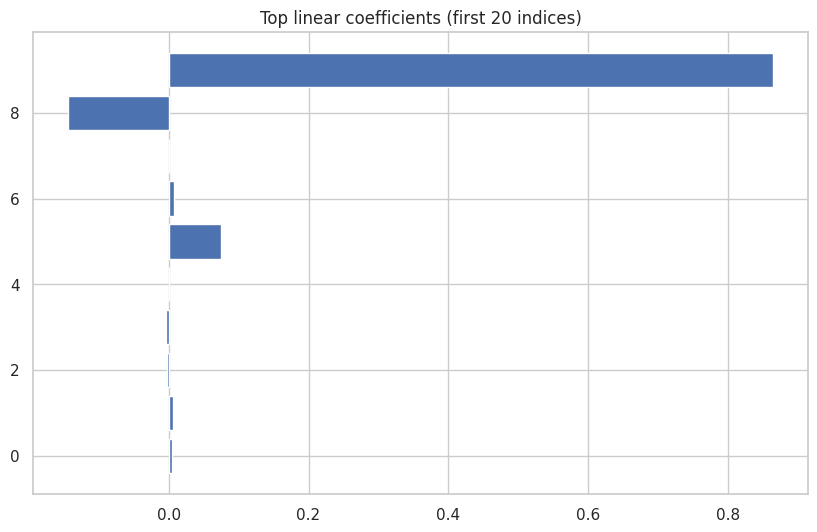

In [173]:
# Feature importance (if best model is tree-based) or linear coefficients
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    # Build feature names from preprocessor (OneHotEncoder expands categories)
    # We'll attempt to retrieve the names if the preprocessor has OneHotEncoder
    feature_names = []
    # numeric features
    feature_names.extend(num_cols)
    # categorical features: try to extract categories from fitted OHE
    try:
        ohe = preprocessor.named_transformers_['cat'].named_steps['ohe']
        cat_names = ohe.get_feature_names_out(cat_cols).tolist()
        feature_names.extend(cat_names)
    except Exception:
        # fallback to numeric-only names
        pass
    # Trim/pad to length
    feature_names = feature_names[:len(importances)]
    feat_imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
    feat_imp_df = feat_imp_df.sort_values("importance", ascending=False).head(20)
    display(feat_imp_df)
    sns.barplot(x="importance", y="feature", data=feat_imp_df)
    plt.title("Top feature importances (best model)")
    plt.show()
else:
    # Linear model coefficients
    if hasattr(best_model, "coef_"):
        coefs = best_model.coef_
        coef_df = pd.DataFrame({"feature_index": range(len(coefs)), "coef": coefs})
        display(coef_df.sort_values("coef", key=lambda x: x.abs(), ascending=False).head(20))
        plt.figure()
        plt.barh(range(len(coefs[:20])), coefs[:20])
        plt.title("Top linear coefficients (first 20 indices)")
        plt.show()


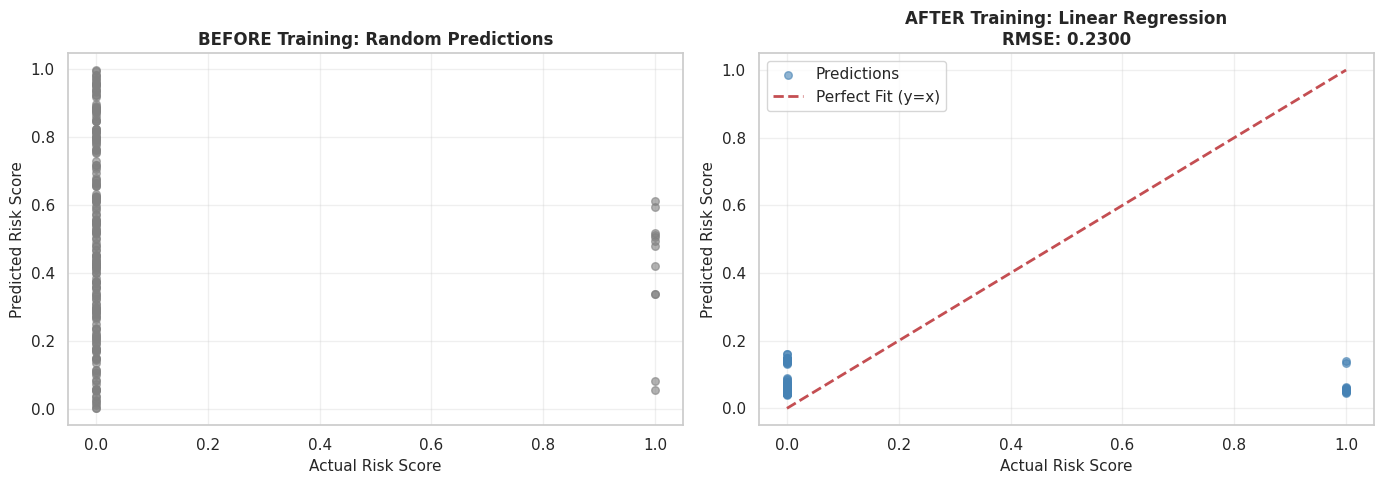

 Red dashed line shows where perfect predictions would fall
 Closer points to red line = better predictions


In [174]:
# SCATTER PLOT: Before and After Linear Regression Training

# Get predictions from linear regression model
lr_model = models["LinearRegression"]
y_pred_lr = lr_model.predict(X_test_raw)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# BEFORE: Random scatter (no relationship)
axes[0].scatter(y_test, np.random.uniform(y_test.min(), y_test.max(), len(y_test)),
                alpha=0.6, color='gray', s=30)
axes[0].set_xlabel('Actual Risk Score', fontsize=11)
axes[0].set_ylabel('Predicted Risk Score', fontsize=11)
axes[0].set_title('BEFORE Training: Random Predictions', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# AFTER: Linear regression fit
axes[1].scatter(y_test, y_pred_lr, alpha=0.6, color='steelblue', s=30, label='Predictions')
# Plot the "perfect fit" line (y=x)
min_val = min(y_test.min(), y_pred_lr.min())
max_val = max(y_test.max(), y_pred_lr.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Fit (y=x)')
axes[1].set_xlabel('Actual Risk Score', fontsize=11)
axes[1].set_ylabel('Predicted Risk Score', fontsize=11)
axes[1].set_title(f'AFTER Training: Linear Regression\nRMSE: {baseline_results["LinearRegression"]["RMSE"]:.4f}',
                  fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f" Red dashed line shows where perfect predictions would fall")
print(f" Closer points to red line = better predictions")

In [175]:
# Save artifacts for deployment
os.makedirs("models", exist_ok=True)
joblib.dump(best_model, "models/best_model.pkl")
joblib.dump(preprocessor, "models/preprocessor.pkl")
joblib.dump(final_features, "models/feature_list.pkl")
print("Saved: models/best_model.pkl, models/preprocessor.pkl, models/feature_list.pkl")


Saved: models/best_model.pkl, models/preprocessor.pkl, models/feature_list.pkl


In [198]:
from IPython.utils.text import Path
print("Prediction script for task 2")

def predict_cervical_cancer_risk(input_data_dict):
    name_map = {
        "age": "Age",
        "num_partners": "Number of sexual partners",
        "first_sex": "First sexual intercourse",
        "num_preg": "Num of pregnancies",
        "smokes": "Smokes",
        "smokes_years": "Smokes (years)",
        "smokes_packs": "Smokes (packs/year)",
        "hormonal_contraceptives": "Hormonal Contraceptives",
        "hormonal_contraceptives_years": "Hormonal Contraceptives (years)",
        "iud": "IUD",
        "iud_years": "IUD (years)",
        "stds": "STDs",
        "stds_number": "STDs (number)",
        "stds_condylomatosis": "STDs:condylomatosis",
        "stds_cervical_condylomatosis": "STDs:cervical condylomatosis",
        "stds_vaginal_condylomatosis": "STDs:vaginal condylomatosis",
        "stds_vulvo_perineal": "STDs:vulvo-perineal condylomatosis",
        "stds_syphilis": "STDs:syphilis",
        "stds_pelvic": "STDs:pelvic inflammatory disease",
        "stds_herpes": "STDs:genital herpes",
        "stds_molluscum": "STDs:molluscum contagiosum",
        "stds_aids": "STDs:AIDS",
        "stds_hiv": "STDs:HIV",
        "stds_hepatitis_b": "STDs:Hepatitis B",
        "stds_hpv": "STDs:HPV",
        "stds_num_diag": "STDs: Number of diagnosis",
        "dx_cancer": "Dx:Cancer",
        "dx_hpv": "Dx:HPV",
        "dx": "Dx",
        "hinselmann": "Hinselmann",
        "schiller": "Schiller",
        "citology": "Citology",
        "biopsy": "Biopsy"
    }

    converted = {}
    for key, value in input_data_dict.items():
        mapped_key = name_map.get(key, key)
        converted[mapped_key] = value


    # Load saved model artifacts
    model = joblib.load("/content/models/best_model.pkl")
    preprocessor = joblib.load("/content/models/preprocessor.pkl")
    feature_list = joblib.load("/content/models/feature_list.pkl")



    # ensure all required features are present
    for feature in feature_list:
        if feature not in converted:
            converted[feature] = 0


    # Convert input dictionary to df
    input_df = pd.DataFrame([converted])[feature_list]

    # Apply preprocessing
    input_transformed = preprocessor.transform(input_df)

    # Make prediction
    risk_score = float(model.predict(input_transformed)[0])

    risk_score = np.clip(risk_score, 0.0, 1.0)

    # Intepretation of risk level

    if risk_score < 0.06:
      risk_level = "LOW"
      recommendation = "Routine screening recommended"

    elif risk_score < 0.12:
      risk_level = "MODERATE"
      recommendation = "Consider additional screening and consultation"

    elif risk_score < 0.16:
      risk_level = "HIGH"
      recommendation = "Consult healthcare provider soon for evaluation"

    else:
      risk_level = "VERY HIGH"
      recommendation = "Immediate medical intervention required"

    return {
        "risk_score": risk_score,
        "risk_level": risk_level,
        "recommendation": recommendation,
        "model_used": type(model).__name__
    }





Prediction script for task 2


In [177]:
feature_list = joblib.load("/content/models/feature_list.pkl")
print("n features:", len(feature_list))
print(feature_list)

n features: 10
['Number of sexual partners', 'First sexual intercourse', 'Smokes', 'Hormonal Contraceptives', 'IUD (years)', 'STDs', 'STDs (number)', 'STDs:cervical condylomatosis', 'STDs:pelvic inflammatory disease', 'STDs:genital herpes']


In [178]:
print(df.columns.tolist())

['Age', 'Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD', 'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis', 'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease', 'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis', 'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology', 'Biopsy', 'CervicalCancer_RiskScore']


In [199]:
test_patient_low = {
  "Number of sexual partners": 1,
  "First sexual intercourse": 20,
  "Smokes": 0,
  "Hormonal Contraceptives": 0,
  "IUD (years)": 0,
  "STDs": 0,
  "STDs (number)": 0,
  "STDs:cervical condylomatosis": 0,
  "STDs:pelvic inflammatory disease": 0,
  "STDs:genital herpes": 0
}


# Test data - MODERATE RISK CASE
test_patient_moderate = {
  "Number of sexual partners": 3,
  "First sexual intercourse": 16,
  "Smokes": 1,
  "Hormonal Contraceptives": 1,
  "IUD (years)": 2,
  "STDs": 1,
  "STDs (number)": 1,
  "STDs:cervical condylomatosis": 0,
  "STDs:pelvic inflammatory disease": 0,
  "STDs:genital herpes": 0
}


# Test data -  HIGH RISK CASE
test_patient_high = {
    "Number of sexual partners": 12,
    "First sexual intercourse": 13,
    "Smokes": 1,
    "Hormonal Contraceptives": 1,
    "IUD (years)": 8,
    "STDs": 1,
    "STDs (number)": 5,
    "STDs:cervical condylomatosis": 1,
    "STDs:pelvic inflammatory disease": 1,
    "STDs:genital herpes": 1
}

print("\n[TEST 1: LOW RISK CASE]")
result1 = predict_cervical_cancer_risk(test_patient_low)
print(f"  Risk Score: {result1['risk_score']:.4f}")
print(f"  Risk Level: {result1['risk_level']}")
print(f"  Recommendation: {result1['recommendation']}")
print(f"  Model Used: {result1['model_used']}")

# Test MODERATE RISK case
print("\n[TEST 2: MODERATE RISK CASE]")
result2 = predict_cervical_cancer_risk(test_patient_moderate)
print(f"  Risk Score: {result2['risk_score']:.4f}")
print(f"  Risk Level: {result2['risk_level']}")
print(f"  Recommendation: {result2['recommendation']}")
print(f"  Model Used: {result2['model_used']}")

# Test HIGH RISK case
print("\n[TEST 3: HIGH RISK CASE]")
result3 = predict_cervical_cancer_risk(test_patient_high)
print(f"  Risk Score: {result3['risk_score']:.4f}")
print(f"  Risk Level: {result3['risk_level']}")
print(f"  Recommendation: {result3['recommendation']}")
print(f"  Model Used: {result3['model_used']}")



[TEST 1: LOW RISK CASE]
  Risk Score: 0.0592
  Risk Level: LOW
  Recommendation: Routine screening recommended
  Model Used: LinearRegression

[TEST 2: MODERATE RISK CASE]
  Risk Score: 0.1353
  Risk Level: HIGH
  Recommendation: Consult healthcare provider soon for evaluation
  Model Used: LinearRegression

[TEST 3: HIGH RISK CASE]
  Risk Score: 0.9169
  Risk Level: VERY HIGH
  Recommendation: Immediate medical intervention required
  Model Used: LinearRegression
